# Causal Inference and Discovery in Python

## Chapter 01 - Causality – Hey, We Have Machine Learning, So Why Even Bother?

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from itertools import combinations
from scipy import stats
import networkx as nx
import statsmodels.api as sm

plt.style.use('fivethirtyeight')
COLORS = ['#00B0F0','#FF0000']

### Confounding

In [3]:
# Let's set random seed for reproducibility
np.random.seed(45)

# `b` represents our confounder
b = np.random.rand(100)

# `a` and `c` are causally independent of each other, but they are both children of `b` 
a = b + .1 * np.random.rand(100)
c = b + .3 * np.random.rand(100)


# Let's check correlation between `a` and `c`
coef, p_val = stats.pearsonr(a, c)

print(coef.round(2))

0.96


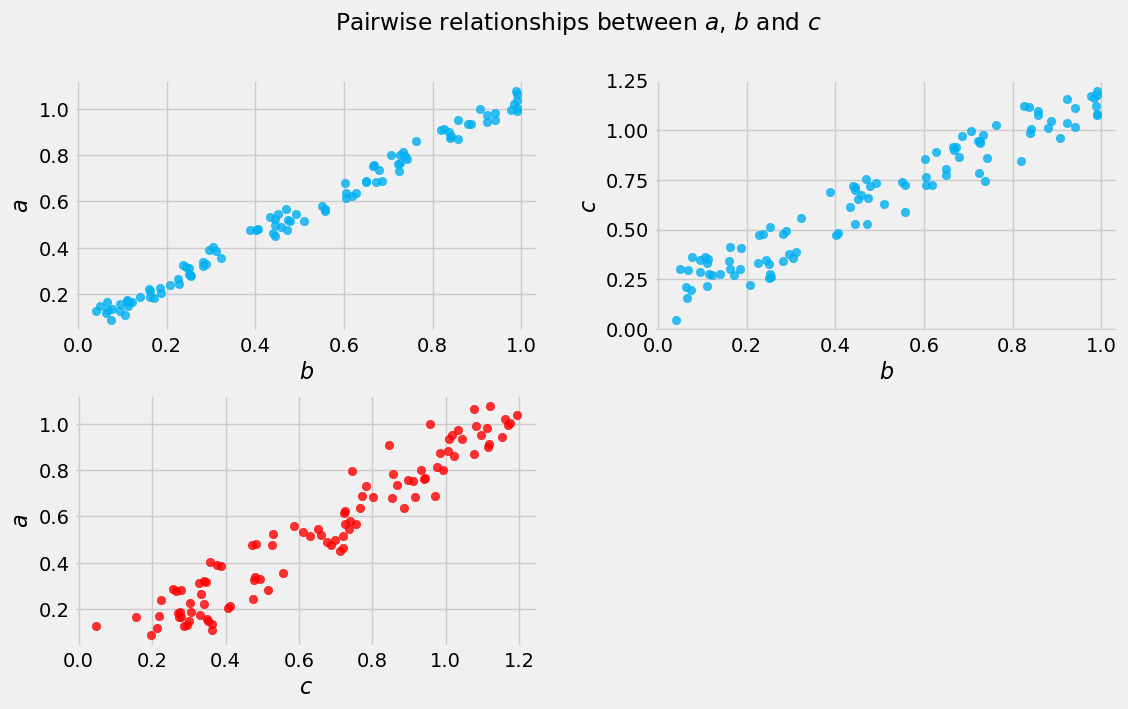

In [4]:
variables = {
    'a': a,
    'b': b,
    'c': c
}

plt.figure(figsize=(12, 7))

for i, (var_1, var_2) in enumerate([('b', 'a'), ('b', 'c'), ('c', 'a')]):
    
    color = COLORS[1]
    
    if 'b' in [var_1, var_2]:
        color = COLORS[0]
    
    plt.subplot(2, 2, i + 1)
    plt.scatter(variables[var_1], variables[var_2], alpha=.8, color=color)
    
    plt.xlabel(f'${var_1}$', fontsize=16)
    plt.ylabel(f'${var_2}$', fontsize=16)

plt.suptitle('Pairwise relationships between $a$, $b$ and $c$')
plt.subplots_adjust(hspace=.25, wspace=.25)
plt.show()

    The blue points signify a causal relationship while red points signify a spurious relationship, and variables a, b, and c are related in the following way:
    
    • b causes a and c
    • a and c are causally independent

<img align="center" src="images/01.png"     style=" width:400px;  ">

## Chapter 02 - Judea Pearl and the Ladder of Causation

<img align="center" src="images/02.png"     style=" width:800px;  ">

### Ladder of Causation

| **Rung**         | **Action**     | **Question**                                  |
|------------------|----------------|-----------------------------------------------|
| (1) Association | Observing      | How does observing X change my belief in Y?   |
| (2) Intervention | Doing          | What will happen to Y if I do X?              |
| (3) Counterfactual| Imagining     | If I had done X, what would Y be?             |


### (1) Association - Bookstore example

Let the variables be defined as:

$$
U_0 \sim \mathcal{U}(0, 1)
$$

$$
U_1 \sim \mathcal{N}(0, 1)
$$

$$
A := 
\begin{cases}
1 & \text{if } U_0 > 0.61 \\
0 & \text{otherwise}
\end{cases}
$$

$$
B := 
\begin{cases}
1 & \text{if } A + 0.5 \cdot U_1 > 0.2 \\
0 & \text{otherwise}
\end{cases}
$$


In [5]:
# First, we'll build a structural causal model (SCM)
class BookSCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_0 = stats.uniform()        # U0 is a continuous random variable uniformly distributed between 0 and 1
        self.u_1 = stats.norm()           # U1 is a normally distributed random variable, with a mean value of 0 and a standard deviation of 1
        
    def sample(self, sample_size=100):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_0 = self.u_0.rvs(sample_size)
        u_1 = self.u_1.rvs(sample_size)
        a = u_0 > .61
        b = (a + .5 * u_1) > .2
        
        return a, b  


# Let's initialize our SCM
scm = BookSCM(random_seed=45)

# ...and sample from it
buy_book_a, buy_book_b = scm.sample(100)

# Sanity check
buy_book_a.shape, buy_book_b.shape

((100,), (100,))

In [6]:
a

array([1.04138646, 0.57933317, 0.33854587, 0.13468835, 0.44891165,
       0.51813449, 0.14752271, 0.18599604, 0.16327545, 0.63527708,
       0.95292094, 0.69086016, 0.99376902, 0.47782642, 0.62573978,
       0.31999729, 0.99445546, 0.68595653, 0.4641619 , 0.33040882,
       0.51673667, 0.1470143 , 0.24172008, 0.51662329, 0.31651303,
       0.47541015, 0.91181582, 0.08589202, 0.97661077, 0.26625309,
       0.80285167, 0.17102694, 0.68198384, 0.48213916, 0.90235967,
       0.28781339, 0.48947682, 0.56838224, 0.28285345, 0.16910605,
       0.76550358, 0.38513895, 0.91277969, 0.54487845, 0.1543879 ,
       0.93504085, 0.78285256, 0.16413221, 0.87104014, 0.12980022,
       0.22586898, 0.18365635, 0.94253623, 0.75422202, 0.27842418,
       0.31212629, 1.02305993, 0.73709132, 0.47525253, 0.11588399,
       0.52615683, 0.23962938, 0.35391167, 0.68499581, 0.73352435,
       0.56666604, 0.20412217, 0.3900738 , 0.1847773 , 0.12550794,
       0.54664745, 1.06542539, 0.93439979, 0.21234898, 0.40213

In [7]:
buy_book_a

array([ True, False, False, False, False, False, False, False, False,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False,  True, False, False, False,  True, False,
       False, False, False, False,  True, False,  True, False, False,
        True,  True, False,  True, False, False, False,  True,  True,
       False, False,  True,  True, False, False, False, False, False,
        True,  True, False, False, False, False, False, False,  True,
        True, False, False, False,  True,  True, False, False, False,
       False,  True, False,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False,  True,  True, False,  True,
        True])

In [8]:
len(buy_book_a)

100

In [9]:
# Let's compute probabilities
proba_book_a = buy_book_a.sum() / buy_book_a.shape[0]
proba_book_b = buy_book_b.sum() / buy_book_b.shape[0]

print(f'Probability of buying book A: {proba_book_a:0.3f}')
print(f'Probability of buying book B: {proba_book_b:0.3f}')

# ...and conditional probailities
proba_book_a_given_book_b = np.where(buy_book_b, buy_book_a, 0).sum() / buy_book_b.sum()
proba_book_b_given_book_a = np.where(buy_book_a, buy_book_b, 0).sum() / buy_book_a.sum()

print(f'Probability of buying book A given B: {proba_book_a_given_book_b:0.3f}')
print(f'Probability of buying book B given A: {proba_book_b_given_book_a:0.3f}')

Probability of buying book A: 0.390
Probability of buying book B: 0.580
Probability of buying book A given B: 0.638
Probability of buying book B given A: 0.949


### (2) Intervention

Let the variables be defined as:

$$
U_0 \sim \mathcal{N}(0, 1)
$$

$$
U_1 \sim \mathcal{N}(0, 1)
$$

$$
A := U_0
$$

$$
B := 5A + U_1
$$

In [10]:
SAMPLE_SIZE = 100
np.random.seed(45)

u_0 = np.random.randn(SAMPLE_SIZE)     # Generate SAMPLE_SIZE samples from standard normal for U0 (unobserved cause of A)
u_1 = np.random.randn(SAMPLE_SIZE)     # Generate SAMPLE_SIZE samples from standard normal for U1 (unobserved cause of B)
a = u_0                                # Set A as directly caused by U0 (no noise)
b = 5 * a + u_1                        # B is caused by A (coefficient 5) and U1 (confounder/noise)

r, p = stats.pearsonr(a, b)            # Calculate Pearson correlation between A and B


print(f'Mean of B before any intervention: {b.mean():.3f}')
print(f'Variance of B before any intervention: {b.var():.3f}')
print(f'Correlation between A and B:\nr = {r:.3f}; p = {p:.3f}\n')

a = np.array([1.5] * SAMPLE_SIZE)      # Intervene on A: set all values to 1.5 (do(A=1.5))
b = 5 * a + u_1                        # Recalculate B using intervened A and original noise U1

print(f'Mean of B after the intervention on A: {b.mean():.3f}')
print(f'Variance of B after the intervention on A: {b.var():.3f}\n')

a = u_0                                # Reset A to original values from U0
b = np.random.randn(SAMPLE_SIZE)       # Intervene on B: set it to random noise (break all causal links)

r, p = stats.pearsonr(a, b)            # Recalculate correlation between A and new (random) B

print(f'Mean of B after the intervention on B: {b.mean():.3f}')
print(f'Variance of B after the intervention on B: {b.var():.3f}')
print(f'Correlation between A and B after intervening on B:\nr = {r:.3f}; p = {p:.3f}\n')

Mean of B before any intervention: -0.620
Variance of B before any intervention: 22.667
Correlation between A and B:
r = 0.978; p = 0.000

Mean of B after the intervention on A: 7.575
Variance of B after the intervention on A: 1.003

Mean of B after the intervention on B: 0.186
Variance of B after the intervention on B: 0.995
Correlation between A and B after intervening on B:
r = -0.023; p = 0.821



Note that the correlation between A and B dropped to almost zero (r = −.023), and the corresponding
p-value indicates a lack of significance (p = .821), it could easily have occurred by chance. This indicates that after the intervention, A and
B became (linearly) independent. This result suggests that there is no causal link from B to A. At the
same time, previous results demonstrated that intervening on A changes B, indicating that there is
a causal link from A to B.

### (3) Counterfactuals
We'll use the following SCM:


• `Abduction`: Using evidence to calculate values of exogenous variables

• `Modification` (originally called an action): Replacing the structural equation for the treatment with a counterfactual value

• `Prediction`: Using the modified SCM to compute the new value of the outcome under the counterfactual

#### Summary Table

| **Step**       | **Action**                                 | **Purpose**                                                  |
|----------------|---------------------------------------------|---------------------------------------------------------------|
| Abduction      | Infer $U$ from observed $T$, $Y$            | Understand what caused the observed outcome                   |
| Modification   | Replace model equation with new $T$         | Simulate a new, counterfactual world                          |
| Prediction     | Plug $U$ into the new model                 | Compute what $Y$ would have been in that new world            |


In [11]:
class CounterfactualSCM:                             # Define a class representing a Structural Causal Model for counterfactual analysis
    
    def abduct(self, t, y):                          # Abduction step: infer the latent variable u from treatment t and outcome y
        return (t + y - 1)/(2*t - 1)                 # Formula derived from solving the SCM equations backward

    def modify(self, t):                             # Intervention step: modify the structural equation for a new treatment t
        return lambda u: t * u + (t - 1) * (u - 1)   # Return a new function that takes u and computes the counterfactual outcome

    def predict(self, u, t):                         # Prediction step: use modified model and latent variable u to get outcome
        return self.modify(t)(u)                     # Apply the modified structural equation to u to get predicted outcome


# Instantiate the model
coffee = CounterfactualSCM()
t = 1                             # Observed treatment
y = 1                             # Observed outcome

# Infer U from observed T, Y
u = coffee.abduct(t=t, y=y)
u                                 # Infer exogenous variable

1.0

In [12]:
# Make a prediction based on counterfactual interest (t=0)
coffee.predict(u=u, t=0)                             

0.0

## Chapter 03 - Regression, Observations, and Interventions

### Regression

Let's build a model according to the following specification:

$$
\hat{y}_i = 1.12 + 0.93x_i + 0.5\epsilon_i
$$

where $ \epsilon \sim \mathcal{N}(0, 1) $

In [13]:
# Set the seed for reproducibility
np.random.seed(45)

# No. of samples
N_SAMPLES = 5000

# Define true model parameters
alpha = 1.12
beta = 0.93
epsilon = np.random.randn(N_SAMPLES)

# Generate X
X = np.random.randn(N_SAMPLES)

# Compute Y
y = alpha + beta * X + 0.5 * epsilon

# Statsmodel models require us to add constant
X = sm.add_constant(X)

# Print the first 5 rows of X
print(X[:5, :])

[[ 1.          0.11530002]
 [ 1.         -0.43617719]
 [ 1.         -0.54138887]
 [ 1.         -1.64773122]
 [ 1.         -0.32616934]]


In [14]:
# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

# Print results summary
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 1.681e+04
Date:                Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:55:14   Log-Likelihood:                -3615.0
No. Observations:                5000   AIC:                             7234.
Df Residuals:                    4998   BIC:                             7247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1243      0.007    159.391      0.0

The coefficient marked const is α, the estimate of the true α * parameter, while the coefficient
marked x1 is β, the estimate of β*. They are slightly different from their true counterparts (α * = 1.12,
β* = 0.93). This is because we made our model noisy by adding the ϵ term. You can see that both
coefficients are associated with p-values below 0.001 (check the column named P>|t|), which
indicates that they are **statistically significant** at the customary p < .05 level.

In [15]:
# Generate predictions
y_pred = fitted_model.predict(X)

y_pred

array([ 1.23046978,  0.7224734 ,  0.62555706, ...,  1.08987792,
        0.90607495, -0.53233118])

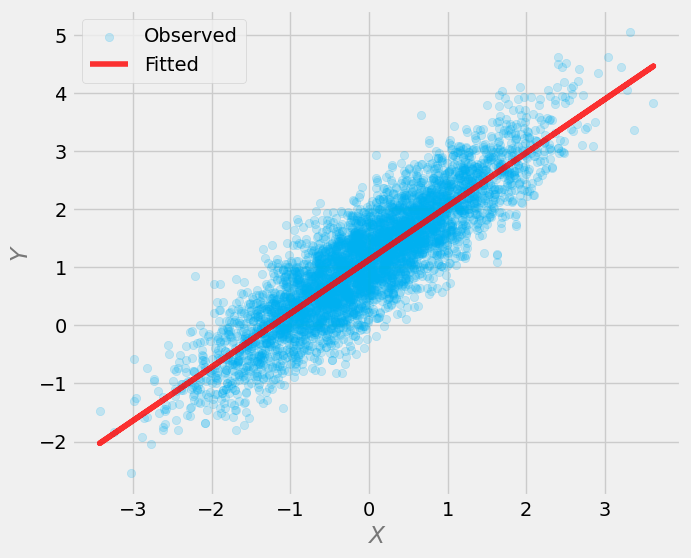

In [16]:
# Plot
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 1], y, color=COLORS[0], label='Observed', alpha=.2)
plt.plot(X[:, 1], y_pred, color=COLORS[1], label='Fitted', alpha=.8)
plt.xlabel('$X$', alpha=.5)
plt.ylabel('$Y$', alpha=.5)
legend = plt.legend()

# Set legend handle opacity
for handle in legend.get_lines():        
    handle.set_alpha(0.8)
    
plt.show();

### Reversed model
Now we're going to reverse the ordering of variables and regress **X** on **Y**.

In [17]:
# Let's remove the constant (now X becomes our target variable) 
x_rev = X[:, 1]

# Let's add constant (now Y becomes our predictor)
Y_rev = sm.add_constant(y)

In [18]:
# Instantiate the model and fit it
model_rev = sm.OLS(x_rev, Y_rev)
fitted_model_rev = model_rev.fit()

# Print results summary
print(fitted_model_rev.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 1.681e+04
Date:                Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:55:14   Log-Likelihood:                -3375.0
No. Observations:                5000   AIC:                             6754.
Df Residuals:                    4998   BIC:                             6767.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9441      0.010    -96.048      0.0

In [19]:
# Generate predictions
x_pred_rev = fitted_model_rev.predict(Y_rev)

x_pred_rev

array([ 0.09395   , -0.23735583, -0.59349923, ..., -0.99222213,
       -0.23147299, -0.99463646])

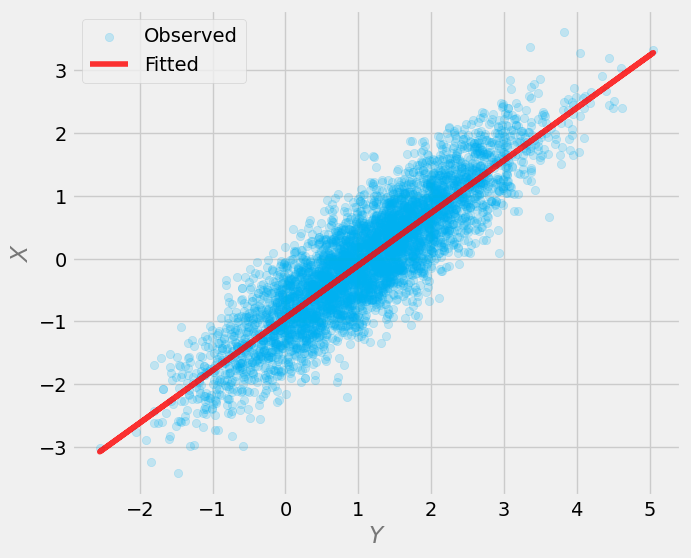

In [20]:
# Plot
plt.figure(figsize=(7, 6))
plt.scatter(Y_rev[:, 1], x_rev, color=COLORS[0], label='Observed', alpha=.2)
plt.plot(Y_rev[:, 1], x_pred_rev, color=COLORS[1], label='Fitted', alpha=.8)
plt.xlabel('$Y$', alpha=.5)
plt.ylabel('$X$', alpha=.5)
legend = plt.legend()

# Set legend handle opacity
for handle in legend.get_lines():        
    handle.set_alpha(0.8)

plt.show()

### Should we always control for all available covariates?

In [21]:
import graphviz

In [22]:
# Create a directed graph
g_1 = graphviz.Digraph(format='png')

# Add nodes
nodes_1 = ['A', 'X', 'B', 'Y']
[g_1.node(n) for n in nodes_1]

g_1.edges(['AX', 'XB', 'AY', 'YB'])

In [23]:
# Render for print
#g_1.render('img/ch_03_graph_01')

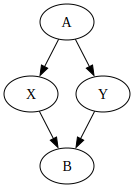

In [24]:
# Display the graph
g_1

In [25]:
# Set random seed for reproducibility
np.random.seed(45)

# Define the sample size
N_SAMPLES = 1000

# Build the graph (note that the coefficients are arbitrarily chosen)
a = np.random.randn(N_SAMPLES)
x = 2 * a + 0.5 * np.random.randn(N_SAMPLES)
y = 2 * a + 0.5 * np.random.randn(N_SAMPLES)
b = 1.5 * x + 0.75 * y

In [26]:
# Define four model variants
variants = [
    [x],
    [x, a],
    [x, b],
    [x, a, b]
]

# Fit models iteratively and store the results
results = []
for variant in variants:
    X = sm.add_constant(np.stack(variant).T)
    
    # Instantiate the model and fit it
    model = sm.OLS(y, X)
    fitted_model = model.fit()
    
    results.append((fitted_model.params, fitted_model.pvalues))
    
    print(f'Params: {fitted_model.params.round(3)}')
    print(f'p-vals: {fitted_model.pvalues.round(3)}')
    print(f'Signif: {fitted_model.pvalues <= .05}\n')

Params: [-0.02   0.947]
p-vals: [0.359 0.   ]
Signif: [False  True]

Params: [-0.011  0.014  1.967]
p-vals: [0.488 0.657 0.   ]
Signif: [False False  True]

Params: [-0.    -2.     1.333]
p-vals: [0.883 0.    0.   ]
Signif: [False  True  True]

Params: [-0.    -2.     0.     1.333]
p-vals: [0.804 0.    0.091 0.   ]
Signif: [False  True False  True]



What we see is that the only model that recognized the causal independence of
X and Y correctly (large p-value for X, suggesting the lack of significance) is the second model
(Y ~ X + A). This clearly shows us that all other statistical control schemes led to invalid results,
including the model that does not control for any additional variables.

In [27]:
# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

# Print results summary
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.090e+31
Date:                Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:55:16   Log-Likelihood:                 31635.
No. Observations:                1000   AIC:                        -6.326e+04
Df Residuals:                     996   BIC:                        -6.324e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.469e-17    1.4e-16     -0.248      0.8

### Regression and structural models

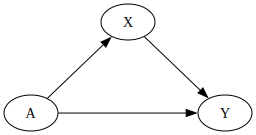

In [28]:
# Create a directed graph
g_2 = graphviz.Digraph(
    format='png',
    graph_attr={
        'rankdir':'LR', 
        'ranksep': '.6',
        'nodesep': '1.5'
    })

# Add nodes
nodes_2 = ['A', 'X', 'Y']
[g_2.node(n) for n in nodes_2]

g_2.edges(['AY', 'AX', 'XY'])

g_2

In [29]:
# Render for print
#g_2.render('img/ch_03_graph_02')

In [30]:
# Set random seed for reproducibility
np.random.seed(45)

# Define the sample size
N_SAMPLES = 1000

# Define the SCM
a = np.random.randn(N_SAMPLES)
x = 2 * a + .7 * np.random.randn(N_SAMPLES)
y = 2 * a + 3 * x + .75 * x**2

Note that our functional assignment contained not only X but also X^2. We want to make sure that
we add the square term to the model as well. This is the simplest way to introduce non-linearity
into a linear regression model. Also, note that the model is still linear in parameters (we only
use addition and multiplication).

Another important thing to notice is that we included A in the model. The reason for this is
that A is a confounder in our dataset and – as we learned before – we need to control for a
confounder in order to get unbiased estimates.

In [31]:
# Statsmodel models require us to add constant
X = sm.add_constant(np.stack([x, x**2, a]).T)

# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

# Print results summary
print(fitted_model.summary(xname=['const', 'x', 'x^2', 'a']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.120e+32
Date:                Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:55:17   Log-Likelihood:                 31120.
No. Observations:                1000   AIC:                        -6.223e+04
Df Residuals:                     996   BIC:                        -6.221e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.552e-15   2.86e-16     15.890      0.0

If we compare the coefficient values to the
true coefficients in our SCM, we can notice that they are exactly the same (y = 2 * a + 3 * x + .75 * x**2)! This is because we modeled
Y as a deterministic function of X and A, not adding any noise.

We can also see that the model correctly decoded the coefficient for the non-linear term (X2). Although
the relationship between X2 and Y is non-linear, they are related by a linear functional assignment.